# Travail Pratique de Machine Learning pour l'octroi de crédit

## Introduction

Dans cette situation, le défi réside dans la mise en place d'une approche modernisée de Big Data/IA pour la prédiction d'octroi de crédit au sein d'une banque. Le responsable de la ligne de produit crédit à la consommation souhaite prendre des décisions éclairées sur l'attribution des crédits en se basant sur des données antérieures.

La banque dispose d'un ensemble de données comprenant plus de 18 500 crédits, chacun caractérisé par un indicateur et 41 paramètres. L'indicateur, figurant dans la colonne "indicatrice" du fichier de données, distingue les crédits bien remboursés des problématiques (1 indique un problème sur le crédit).

Sur le plan financier, la banque réalise un gain de 4 000 € par crédit bien remboursé, mais subit une perte moyenne de 13 000 € par crédit problématique.

La mission consiste à élaborer une solution Data, accompagnée d'un mode d'emploi, répondant à la demande du responsable de la ligne produit. L'objectif final est d'optimiser l'espérance de bénéfice de la banque dans le processus d'octroi de crédit.

In [1]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
IMG_DIR_PATH = 'img'
DATA_DIR_PATH = 'data'

CSV_FILE = os.path.join(DATA_DIR_PATH,'Data_Finance_TrainEtVal_13Nov23.csv')


## Chargement des données

Le Dataset avec lequel nous travaillons se présente sous la forme d'un fichier csv que nous allons charger en dataframe pandas.

In [2]:
df = pd.read_csv(CSV_FILE,sep=';')
df.head()

,Id,GENR,produit,age du bien,mode de paiement,montant demande (centimes),delai paiement,apport,apport %,date demande,...,impayes,charge,fichage3,revenus,secteur activite,code postal,Chiffre d'affaires,Capital social,Indicatrice,Label
0,4212339,VP,LLD,0,10,4967310,10,0,0.0,04/01/2010 09:59,...,0,0,0,0,77,95100,0,200000,0,Train
1,4212408,VP,CB,0,10,1228763,0,245753,20.0,04/01/2010 10:58,...,0,0,0,100000,41,93600,0,750000,0,Train
2,4212504,VU,CB,0,10,1262250,0,189338,15.0,04/01/2010 12:44,...,0,0,0,100000,43,47130,0,500000,0,Train
3,4212509,,LLD,0,10,1500000,10,0,0.0,04/01/2010 13:19,...,0,0,0,400000,66,67500,0,1000000,0,Train
4,4212561,VU,LLD,0,10,2393850,10,0,0.0,04/01/2010 14:43,...,0,0,0,300000,49,60110,0,750000,0,Train


Le dataset chargé, nous pouvons désormais avoir une vue d'ensemble des données à prédire correctement à savoir le label `Indicatrice` qui renseigne sur l'état du remboursement d'un client. Nous allons faire un simple plot de la répartition des `Indicatrice`s.

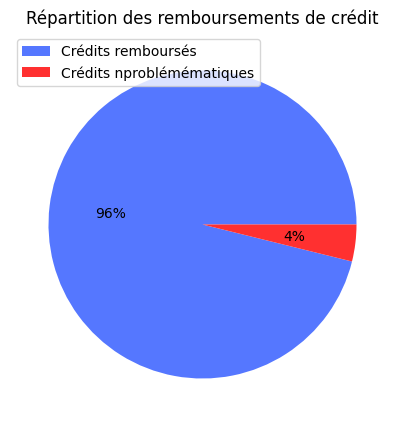

In [3]:

val_counts = df['Indicatrice'].value_counts()
val_counts.index = ['Crédits remboursés', 'Crédits nproblémématiques']
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111)
ax.pie(val_counts, autopct='%1.0f%%', colors=["#5577FF", "#FF3030"])
ax.set_title('Répartition des remboursements de crédit')
ax.legend(val_counts.index, loc='upper left')
fig.savefig(os.path.join(IMG_DIR_PATH,'pie_chart.png'), dpi=300)
plt.show()

Nous remarquons clairement que les prêts avec défaut de remboursement sont très minimes sur l'ensemble du dataset, il faudra donc faire en sorte d'élaborer des modèles qui seront capable d'évaluer avec précision l'état d'un remboursement.

## Nettoyage des données

Avant de traiter la donnée, il faut être en mesure de la manipuler. Pour ce faire il faut la *'nettoyer'* afin de la rendre utilisable.

### Typage adéquat des valeurs du dataset.

Le but ici est d'avoir une homogénéité entre le type réel des données et les types pandas (`dtype`).

In [4]:
for col in df.columns:
  if(df[col].apply(pd.to_numeric, errors='coerce').notna().all()):
    df[col] = (df[col].apply(pd.to_numeric, errors='coerce'))

### Numérisation de certaines valeurs catégoriques

La plupart des modèles prennent en entrée des valeurs numériques, afin d'enrichir nos données d'entrée nous allons nous permettre d'encoder certaines valeurs de type `object` (des chaines de caractères) sous forme d'entiers. Mais d'abord cherchons les données catégoriques avec un nombre de valeurs uniques inférieur à 10. 

In [5]:
column_with_yes_or_no = []
print('Valeurs catégorielles avec moins de 10 valeurs uniques : ')
print(7*'-')
for col in df.columns:
  unique_values = df[col].unique()
  if(df[col].dtype == 'object' ):
    if(len(unique_values) < 10):
      print(col, unique_values)
    if('N' in unique_values and 'O' in unique_values):
      column_with_yes_or_no.append(col)


Valeurs catégorielles avec moins de 10 valeurs uniques : 
-------
GENR ['VP' 'VU' ' ']
produit ['LLD' 'CB' 'CC' 'TP']
alerte fraude ['N' 'O']
Connu ['N' 'O']
fichage ['N' 'O' ' ']
incapacite [' ' 'N' 'O']
procédure collective BdF ['N' 'O']
procédure collective ORT ['N' 'O']
contentieux ['N' 'H' 'O']
cotation dirigeant ['0' '40' 'ZZZZZZ' ' ' '60' '50']
fichage1 ['N' 'O' ' ']
dirigeant client ['N' 'O']
fichage2 ['N' 'O' ' ']
Label ['Train' 'Validation']


Nous remarquons que le dataset possède beaucoup de valeurs littérales qui peuvent être interprétées comme booléenes (colonne oui ou non). Nous allons donc les garder pour les convertir en entier. 

In [6]:

print('Colonnes avec des valeurs oui/non : ')
for col in column_with_yes_or_no:
  print(f'- {col}')

Colonnes avec des valeurs oui/non : 
- alerte fraude
- Connu
- fichage
- incapacite
- procédure collective BdF
- procédure collective ORT
- contentieux
- fichage1
- dirigeant client
- fichage2


A partir des colonnes susmentionnées, nous allons ici convertir toutes les valeurs positives (`'O'`)à 1 et 0 pour `'N'` ou en cas d'absence de donnée.

In [7]:
clean_df = df.copy()

for col in column_with_yes_or_no:
  clean_df[col] = clean_df[col].apply(lambda x: 1 if x == 'O' else 0).astype('int64')

Nous gardons ensuite les données catégoriques nécessaires telles que `'GENR'` ou `'produit'` et retirer les colonnes qui ne sont d'aucune utilité pour nos modèle telles que :
- `'Id'` l'identifiant du client
- '`apport %`' cette donnée est redondante étant donné que l'apport est déjà présent dans la colonne `'apport'`.
- `'date demande'` que nous supposons comme n'ayant aucune causalité sur le remboursement d'un prêt.

In [8]:

categorical_columns_to_keep = ['GENR','produit']
clean_df['Label'] = clean_df['Label'].apply(lambda x: 1 if x == 'Train' else 0).astype('int64')
numerical_columns = [col for col in clean_df.columns if clean_df[col].dtype != 'object' and col not in column_with_yes_or_no]
clean_df = clean_df[column_with_yes_or_no+numerical_columns+categorical_columns_to_keep].drop(['Id','apport %'],axis=1)

print('Colonnes du jeu de données nettoyé : ')
for i,col in enumerate(clean_df.columns,1):
  end = ' | ' if i%5 != 0 else '\n'
  print(f'{col}', end=end)
  

Colonnes du jeu de données nettoyé : 
alerte fraude | Connu | fichage | incapacite | procédure collective BdF
procédure collective ORT | contentieux | fichage1 | dirigeant client | fichage2
age du bien | mode de paiement | montant demande (centimes) | delai paiement | apport
duree | existence impaye regularise | presence homonyme | Montant | effets impayes
montant impayes internes | age dirigeant | impayes | charge | fichage3
revenus | Chiffre d'affaires | Capital social | Indicatrice | Label
GENR | produit | 

In [9]:
clean_df.to_csv(os.path.join(DATA_DIR_PATH,'data_clean.csv'),index=False)
clean_categorical_columns = [col for col in clean_df.columns if clean_df[col].dtype == 'object']
clean_categorical_columns

['GENR', 'produit']

In [10]:
from sklearn.preprocessing import LabelEncoder
one_hot_encoded_df = pd.get_dummies(clean_df, columns=clean_categorical_columns)
label_encoded_df = clean_df.copy()

label_encoder = LabelEncoder()

# Appliquer le Label Encoding colonne par colonne
for column in label_encoded_df.select_dtypes(include=['object']).columns:
    label_encoded_df[column] = label_encoder.fit_transform(label_encoded_df[column])

df_to_treat = label_encoded_df.copy()

In [11]:
X_train = df_to_treat[df_to_treat['Label'] == 1].drop(['Label','Indicatrice'], axis=1)
X_test = df_to_treat[df_to_treat['Label'] == 0].drop(['Label','Indicatrice'], axis=1)
y_train = df_to_treat[df_to_treat['Label'] == 1]['Indicatrice']
y_test = df_to_treat[df_to_treat['Label'] == 0]['Indicatrice']

In [19]:
# Try with xgboost
import xgboost as xgb


xgb_model = xgb.XGBClassifier(random_state=0,learning_rate=0.01, n_estimators=100, max_depth=3,scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      6466
           1       0.13      0.26      0.17       246

    accuracy                           0.91      6712
   macro avg       0.55      0.60      0.56      6712
weighted avg       0.94      0.91      0.92      6712

[[6030  436]
 [ 182   64]]
0.9079261025029798


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

xgb_model = xgb.XGBClassifier()
scale_pos_weight = y_train.value_counts()[0]/y_train.value_counts()[1]
params = {
    'max_depth': [2,3,4],
    'n_estimators': [50,25],
    'scale_pos_weight': [scale_pos_weight,scale_pos_weight*2,scale_pos_weight*0.5],
    'learning_rate': [0.01,0.001]
}
f1_scorer = make_scorer(f1_score)
grid = GridSearchCV(xgb_model, param_grid=params, verbose=1, cv=5, scoring=f1_scorer)
grid.fit(X_train, y_train)
print("Meilleure combinaison de paramètres: ",grid.best_params_)
print("Meilleur score F1: ",grid.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Meilleure combinaison de paramètres:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50, 'scale_pos_weight': 24.168443496801707}
Meilleur score F1:  0.1542760381275995


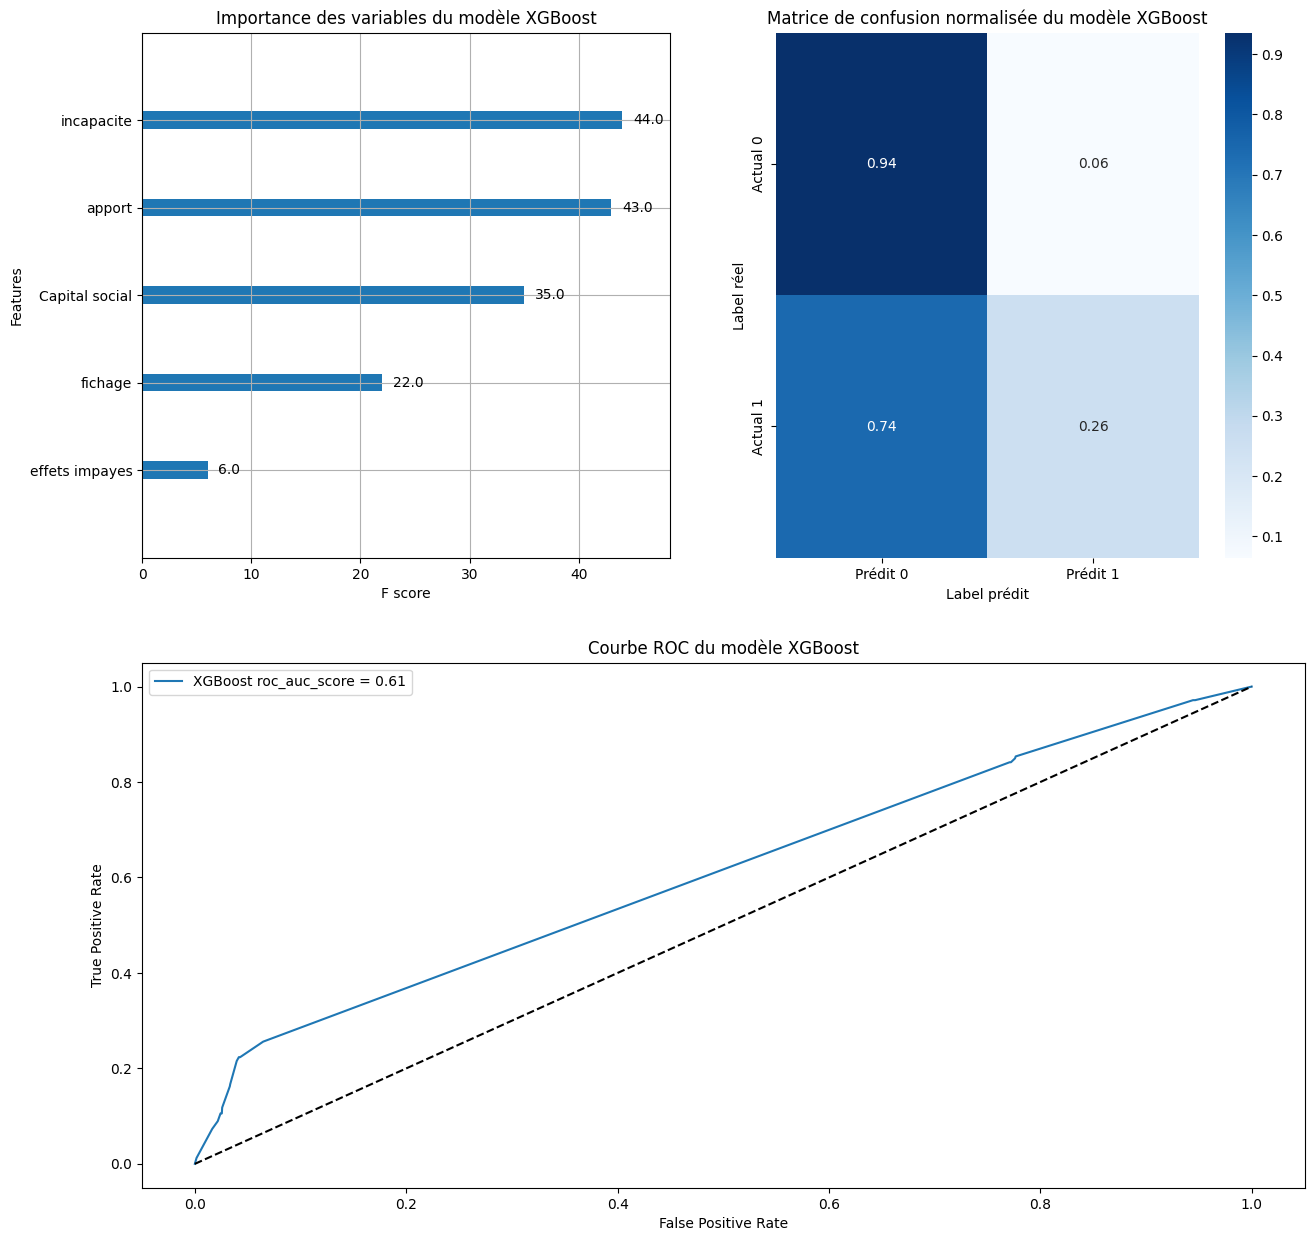

In [42]:

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
# plot feature importance
from xgboost import plot_importance
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 2, 1)
plot_importance(best_model,ax=ax,title='Importance des variables du modèle XGBoost')
# plot confusion matrix

confusion_mat =confusion_matrix(y_test, y_pred)
confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
ax = fig.add_subplot(2, 2, 2)
sns.heatmap(confusion_mat, annot=True, ax=ax,cmap='Blues',fmt='.2f',xticklabels=['Prédit 0','Prédit 1'],yticklabels=['Actual 0','Actual 1'])
ax.set_ylabel('Label réel')
ax.set_xlabel('Label prédit')
ax.set_title('Matrice de confusion normalisée du modèle XGBoost')
# plot roc curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ax = fig.add_subplot(2,1,2)
y_pred_proba = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_score_ = roc_auc_score(y_test, y_pred_proba)
ax.plot(fpr, tpr, label=f'XGBoost roc_auc_score = {roc_auc_score_:.2f}')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Courbe ROC du modèle XGBoost')
ax.legend()
fig.savefig(os.path.join(IMG_DIR_PATH,'xgboost_model.png'), dpi=300)
plt.show()



              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6466
           1       0.50      0.01      0.02       246

    accuracy                           0.96      6712
   macro avg       0.73      0.51      0.50      6712
weighted avg       0.95      0.96      0.95      6712



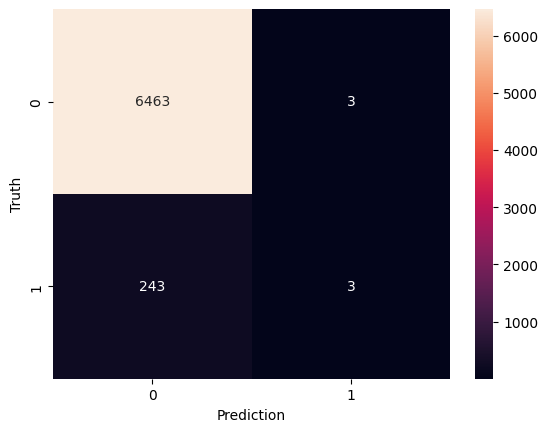

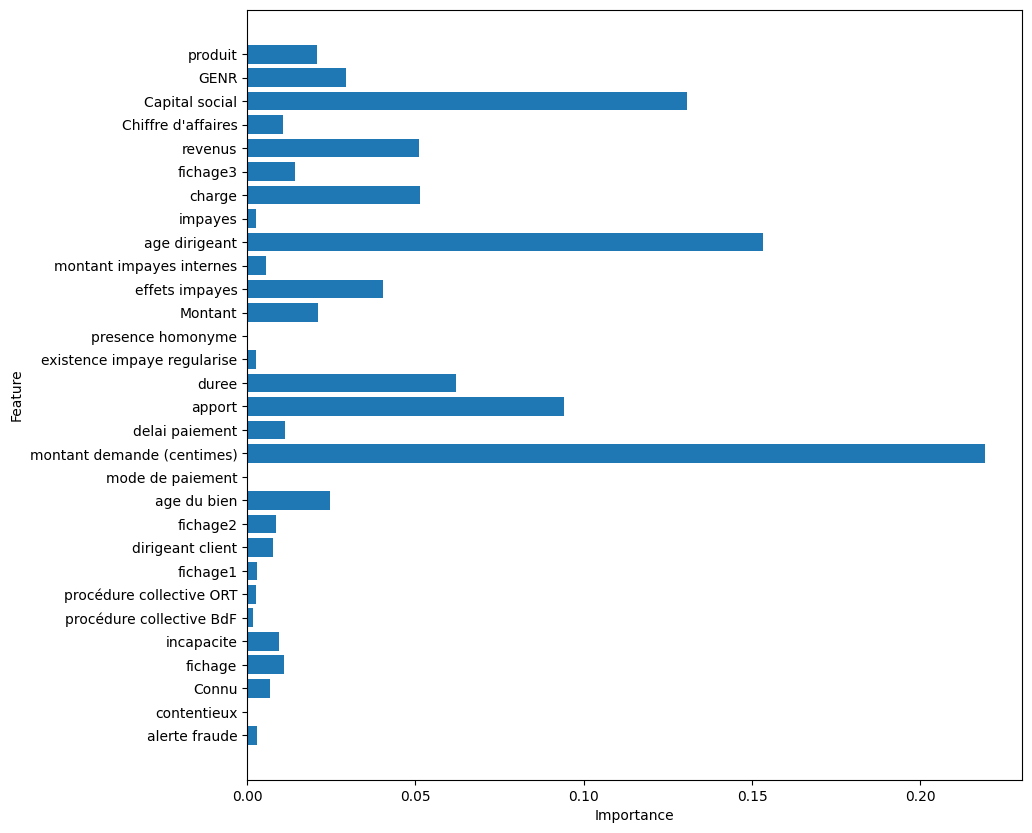

In [71]:
# Apply random forest
random_forest = RandomForestClassifier(n_estimators=200, random_state=0)
random_forest.fit(X_train, y_train)

# Predict
y_pred = random_forest.predict(X_test)

# Evaluate
accuracy_score(y_test, y_pred)

# Evaluate other metrics
confusion_matrix(y_test, y_pred)

# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Truth')

# plot feature importance
plt.figure(figsize=(10,10))
# plot bar order by importance
plt.barh(X_train.columns, random_forest.feature_importances_)

plt.xlabel('Importance')
plt.ylabel('Feature')


print(classification_report(y_test, y_pred))


In [149]:
# Test logistic regression
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6466
           1       0.20      0.00      0.01       246

    accuracy                           0.96      6712
   macro avg       0.58      0.50      0.49      6712
weighted avg       0.94      0.96      0.95      6712



/home/bast7594/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [150]:
# Test MLP
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6466
           1       0.02      0.00      0.01       246

    accuracy                           0.96      6712
   macro avg       0.49      0.50      0.49      6712
weighted avg       0.93      0.96      0.94      6712



In [151]:
# Test SVM
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6466
           1       0.00      0.00      0.00       246

    accuracy                           0.96      6712
   macro avg       0.48      0.50      0.49      6712
weighted avg       0.93      0.96      0.95      6712



/home/bast7594/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bast7594/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bast7594/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
